# Simulating data and power analysis

Tom Ellis, August 2017

Before committing to the time and cost of genotyping samples for a paternity study, it is always sensible to run simulations to test the likely statistical power of your data set. This can help with important questions regaridng study design, such as finding an appropriate balance between the number of families vs offspring per family, or identifying a minimum number of loci to type. Simulated data can also be useful in verifying the results of an analysis.

FAPS provides tools to run such simulations. In this notebook we look look at:

1. Basic tools for simulating genotype data.
2. Automated tools for power analysis.
3. Crafting custom simulations for specialised purposes.
4. Simulations using emprical datasets (under construction).

It is worth noting that I relied on loops for a lot of these tools, for the purely selfish reason that it was easy to code. Loops are of course slow, so if you work with these tools a lot there is ample scope for speeding things up (see especially the functions `make_offspring`, `make_sibships` and `make_power`).

## Simulation building blocks

### Creating `genotypeArray` objects

Simulations are built using `genotypeArrays`. See the section on these [here](http://localhost:8889/notebooks/docs/02%20Genotype%20data.ipynb) for more information.

`make_parents` generates a population of reproductive adults from population allele frequencies.
This example creates ten individuals.
Note that this population will be in Hardy-Weinberg equilibrium, but yours may not.

In [22]:
import numpy as np
from faps import *
import matplotlib as plt
%pylab inline

np.random.seed(37)
allele_freqs = np.random.uniform(0.2, 0.5, 50)
adults = make_parents(10,  allele_freqs, family_name='adult')

Populating the interactive namespace from numpy and matplotlib


There are multiple ways to mate adults to generate offspring. If you supply a set of adults and an integer number of offspring, `make_offspring` mates adults at random.

In [23]:
family1 = make_offspring(parents = adults, noffs=5)
family1.parents

array(['adult_7/adult_2', 'adult_1/adult_6', 'adult_8/adult_3',
       'adult_8/adult_0', 'adult_0/adult_7'], dtype='|S15')

You can also supply an explicit list of dams and sires, in which case the adults are paired in the order they appear in each list.

In [24]:
family2 = make_offspring(parents = adults, dam_list=[7,1,8,8,0], sire_list=[2,6,3,0,7])
family2.parents

array(['adult_7/adult_2', 'adult_1/adult_6', 'adult_8/adult_3',
       'adult_8/adult_0', 'adult_0/adult_7'], dtype='|S15')

Usually we really want to simulate half sib arrays. This can be done using `make_sibships`, which mates a single mother to a set of males.

In [25]:
family3 = make_sibships(parents=adults, dam=0, sires=[1,2,3,4], family_size=5)
family3.parents

array(['adult_0/adult_1', 'adult_0/adult_1', 'adult_0/adult_1',
       'adult_0/adult_1', 'adult_0/adult_1', 'adult_0/adult_2',
       'adult_0/adult_2', 'adult_0/adult_2', 'adult_0/adult_2',
       'adult_0/adult_2', 'adult_0/adult_3', 'adult_0/adult_3',
       'adult_0/adult_3', 'adult_0/adult_3', 'adult_0/adult_3',
       'adult_0/adult_4', 'adult_0/adult_4', 'adult_0/adult_4',
       'adult_0/adult_4', 'adult_0/adult_4'], dtype='|S15')

For uneven sibship sizes, give a list of sizes for each family of the same length as `sires`.

In [26]:
family4 = make_sibships(parents=adults, dam=0, sires=[1,2,3,4], family_size=[5,4,3,2])
family4.parents

array(['adult_0/adult_1', 'adult_0/adult_1', 'adult_0/adult_1',
       'adult_0/adult_1', 'adult_0/adult_1', 'adult_0/adult_2',
       'adult_0/adult_2', 'adult_0/adult_2', 'adult_0/adult_2',
       'adult_0/adult_3', 'adult_0/adult_3', 'adult_0/adult_3',
       'adult_0/adult_4', 'adult_0/adult_4'], dtype='|S15')

### Adding errors

Real data almost always contains errors. For SNP data, these take the form of:

* Missing data, where a locus fails to amplify for some reason
* Genotyping errors, when the observed genotype at a locus is not the actual genotype.

These are straightforward to include in simulated data. First generate some clean data again, and mate the parents.

In [27]:
np.random.seed(85)
allele_freqs = np.random.uniform(0.2, 0.5, 50)
adults = make_parents(10,  allele_freqs, family_name='adult')
progeny = make_sibships(parents=adults, dam=0, sires=[1,2,3,4], family_size=5)

It is best to create the progeny before adding errors. Set the error rates and add errors at random.

In [28]:
d, mu= 0.01, 0.0015 # values for dropout and error rate.
# add genotyping errors
adults_mu  = adults.mutations(mu)
progeny_mu = progeny.mutations(mu)

# add dropouts (to the mutated data)
adults_mu  = adults_mu.dropouts(d)
progeny_mu = progeny.dropouts(d)

`mutations` and `dropouts` make copies of the `genotypeArray`, so the original data remains unchanged. For example:

In [29]:
print adults.missing_data().mean()
print adults_mu.missing_data().mean()

0.0
0.018000000000000002


### Paternity and sibships

Create a `paternityArray` and cluster into sibships as usual (more information on these objects can be found [here](https://github.com/ellisztamas/faps/blob/master/docs/03%20Paternity%20arrays.ipynb) and [here](http://localhost:8889/notebooks/docs/04%20Sibship%20clustering.ipynb).

In [30]:
np.random.seed(85)
allele_freqs = np.random.uniform(0.4, 0.5, 50)
adults = make_parents(10,  allele_freqs, family_name='adult')
progeny = make_sibships(parents=adults, dam=0, sires=[1,2,3,4], family_size=5)
mothers = adults.subset(progeny.parent_index('m', adults.names))
patlik = paternity_array(progeny, mothers, adults, mu=0.0015)
sc = sibship_clustering(patlik)

A very useful tool is the `accuracy` subfunction for `sibshipCluster` objects.
When the paternity and sibship structure are know (seldom the case in real life, but true for simulated data) this returns an array of handy information about the analysis:

0. Binary indiciator for whether the true partition was included in the sample of partitions.
1. Difference in log likelihood for the maximum likelihood partition identified and the true partition. Positive values indicate that the ML partition had greater support than the true partition.
2. Posterior probability of the true number of families.
3. Mean probabilities that a pair of true full sibs are identified as full sibs.
4. Mean probabilities that a pair of true half sibs are identified as half sibs.
5. Mean probabilities that a pair of true half or full sibs are correctly assigned as such (i.e. overall accuracy of sibship reconstruction.
6. Mean (log) probability of paternity of the true sires for those sires who had been sampled (who had non-zero probability in the paternityArray).
7. Mean (log) probability that the sire had not been sampled for those individuals whose sire was truly absent.

In [31]:
sc.accuracy(progeny, adults)

array([1., 0., 1., 1., 1., 1., 1., 0.])

In this example, accuracy is high, but the probability of a missing sire is NaN because all the sires are present, and this number of calculated only for offspring whose sire was absent.

We can adjust the `paternityArray` to see how much this effects the results.
For example, if we remove the sire of the first family (i.e. the male indexed by 1), there is a drop in the accuracy for full-sibling relationships, although half-sibling relationships are unaffected.

In [32]:
patlik.prob_array = patlik.adjust_prob_array(purge = 1, missing_parents=0.25)
sc = sibship_clustering(patlik)
sc.accuracy(progeny, adults)

array([ 1.   , 28.26 ,  0.   ,  0.766,  1.   ,  0.951,  1.   ,  0.093])

In contrast, imagine we had an idea that selfing was strong. How would this affect things?

In [33]:
patlik.prob_array = patlik.adjust_prob_array(selfing_rate=0.5)
sc = sibship_clustering(patlik)
sc.accuracy(progeny, adults)

array([1., 0., 1., 1., 1., 1., 1., 0.])

The results are identical to the unmodified case; FAPS has correctly identifed the correct partition structure in spite of the (incorrect) strong prior for high selfing.

## Automation

It can be tedious to put together your own simulation for every analysis.
FAPS has an automated function that repeatedly creates genotype data, clusters into siblings and calls the `accuracy` function.
You can supply lists of variables and it will evaluate each combination.

For example, this code creates four families of five full siblings with a genotyping error rate of 0.0015.
It considers 30, 40 and 50 loci for 100, 250 or 500 candidate fathers.
Each parameter combination is replicated 10 times.
In reality you would want to do more than this; I have found that results tend to asymptote with 300 simulations.

In [34]:
import numpy as np
from faps import *
import pandas as pd

# Common simulation parameters
r            = 10 # number of replicates
nloci        = [30,40,50] # number of loci
allele_freqs = [0.25, 0.5] # draw allele frequencies 
nadults      = [100,250,500] # size of the adults population
mu           = 0.0015 #genotype error rates
sires        = 4
offspring    = 5

np.random.seed(614)
eventab = make_power(r, nloci, allele_freqs, nadults, sires, offspring, 0, mu)

10 of each parameter combination will be performed.
Simulating arrays with multiple number of loci: [30, 40, 50].
Drawing allele frequencies between 0.25 and 0.5.
Simulating adult populations of multiple sizes: [100, 250, 500].
Simulating 4 families of 5 offspring.
0% of per-locus genotypes will be removed at random.
0.15% of alleles will be mutated at random.
Input error rates taken as the real error rates.
No candidates to be removed.
No prior parameter used for the proportion of missing candidates.
Self-fertilisation rate of 0.
Performing 1000 Monte Carlo draws for sibship inference.

Parameters set. Beginning simulations on Mon Jul 23 17:06:27 2018.


FloatProgress(value=0.0, max=90.0)

Simulations completed after 0.28 minutes.


For convenience, `make_power` provides a summary of the input parameters.
This can be turned off by setting `verbose` to `False`.
Similarly, the progress bar can be removed by setting `progress` to `False`.
This bar uses iPython widgets, and probably won't work outside of iPython, so it may be necessary to turn them off.

The results of make_power are basically the output from the `accuracy` function we saw before, but include information on simulation parameters, and the time taken to create the `paternityArray` and `sibshipCluster` objects. View them by inspecting `eventab`.

Arguments to set up the population work much like those to create `genotypeArrays`, and are quite flexible.
Have a look into the help file (run `make_power?` in Python) for more.
You can also take a look at the [simulations in support of the main FAPS paper](http://localhost:8889/notebooks/manuscript_faps/analysis/A.%20majus%20data%20for%202012.ipynb), which considered a range of contrasting demographic scenarios; the example above is adapted from there.

Error rates and missing candidates are important topics to get a handle on.
We can estimate these parameters (e.g. by genotyping some individuals twice and counting how many loci are different), but we can never completely be sure how close to reality we are.
With that in mind `make_power` allows you to simulate true values mu and the proportion of missing sires, but run the analysis with different values.
The idea is to estimate how wrong you could be before the analysis fails.
For example, this code would simulate the case where you thought that the error rate was 0.0015, and 5% of the candidates went unsampled, but in reality both parameters were double that amount.

In [35]:
make_power(r, nloci, allele_freqs, nadults, sires, offspring, 0,
           mu_input= 0.003,
           mu_real=0.0015,
           unsampled_real=0.1,
           unsampled_input = 0.05)

10 of each parameter combination will be performed.
Simulating arrays with multiple number of loci: [30, 40, 50].
Drawing allele frequencies between 0.25 and 0.5.
Simulating adult populations of multiple sizes: [100, 250, 500].
Simulating 4 families of 5 offspring.
0% of per-locus genotypes will be removed at random.
0.15% of alleles will be mutated at random.
Genotype error rate of 0.003 will be used to construct paternity arrays.
Removing 10.0% of the candidates at random.
Proportion missing canidates set to 0.05.
Self-fertilisation rate of 0.
Performing 1000 Monte Carlo draws for sibship inference.

Parameters set. Beginning simulations on Mon Jul 23 17:06:44 2018.


FloatProgress(value=0.0, max=90.0)

Simulations completed after 0.27 minutes.


,rep,nloci,allele_freq,n_adults,n_sires,array_size,missing_loci,mu_real,mu_input,unsampled_real,...,time_paternity,time_cluster,partition_found,delta_loglik,nfamilies,acc_fs,acc_hs,acc_all,prob_sires,prob_absent
0,0.0,30.0,0.367,100.0,4.0,20.0,0.0,0.0015,0.003,0.1,...,0.006,0.058,0.0,29.76,0.000,0.763,1.000,0.950,1.000,0.0
1,1.0,30.0,0.349,100.0,4.0,20.0,0.0,0.0015,0.003,0.1,...,0.006,0.056,1.0,4.46,0.004,0.800,1.000,0.958,0.900,0.0
2,2.0,30.0,0.379,100.0,4.0,20.0,0.0,0.0015,0.003,0.1,...,0.006,0.056,1.0,1.10,0.181,0.884,1.000,0.976,0.964,0.0
3,3.0,30.0,0.397,100.0,4.0,20.0,0.0,0.0015,0.003,0.1,...,0.006,0.064,0.0,9.75,0.000,0.755,0.973,0.927,1.000,0.0
4,4.0,30.0,0.375,100.0,4.0,20.0,0.0,0.0015,0.003,0.1,...,0.006,0.053,1.0,0.00,0.530,0.941,1.000,0.988,0.989,0.0
5,5.0,30.0,0.380,100.0,4.0,20.0,0.0,0.0015,0.003,0.1,...,0.006,0.055,1.0,1.38,0.142,0.871,1.000,0.973,0.952,0.0
6,6.0,30.0,0.342,100.0,4.0,20.0,0.0,0.0015,0.003,0.1,...,0.006,0.058,1.0,4.63,0.004,0.755,1.000,0.949,0.895,0.0
7,7.0,30.0,0.358,100.0,4.0,20.0,0.0,0.0015,0.003,0.1,...,0.005,0.049,1.0,4.44,0.011,0.900,1.000,0.979,0.951,0.0
8,8.0,30.0,0.385,100.0,4.0,20.0,0.0,0.0015,0.003,0.1,...,0.006,0.058,0.0,27.38,0.000,0.655,1.000,0.927,0.930,0.0
9,9.0,30.0,0.409,100.0,4.0,20.0,0.0,0.0015,0.003,0.1,...,0.006,0.065,1.0,1.49,0.058,0.741,1.000,0.946,0.912,0.0


If you want to perform downstream analysis, you can tell `make_power` to also export each `paternity_Array` and/or `sibshipCluster` object. This is done by setting `return_paternities` and `return_clusters` to `True`. For example, this code pulls out the distribution of family sizes from each `sibshipArray`, and plots it.

No prior parameter used for the proportion of missing candidates.


FloatProgress(value=0.0, max=90.0)

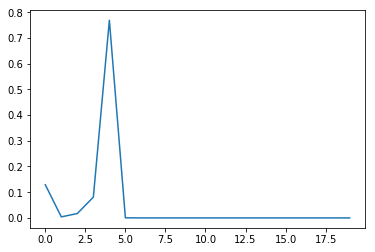

In [36]:
eventab, evenclusters = make_power(r, nloci, allele_freqs, nadults, sires, offspring, 0, mu, return_clusters=True, verbose=False)
even_famsizes = np.array([evenclusters[i].family_size() for i in range(len(evenclusters))])

plt.plot(even_famsizes.mean(0))
plt.show()

## Custom simulations

Once you are familiar with the basic building blocks for generating data and running analysis, creating your own simulations if largely a case of setting up combinations of parameters, and looping over them.
Given the vast array of possible scenarios you could want to simulate, it is impossible to be comprehensive here, so it must suffice to given a couple of examples for inspiration.

### Likelihood for missing sires

In this example is was interested in the performance of the likelihood estimator for a sire being absent.
This is the likelihood of generating the offspring genotype if paternal alleles come from population allele frequencies.
This is what the attribute `lik_abset` in a `paternityArray` tells you.

Ideally this likelihood should be below the likelihood of paternity for the true sire, but higher than that of the other candidates. I suspected this would not be the case when minor allele frequency is low and there are many candidates.

This cell sets up the simulation. I'm considering 50 loci, and mu=0.0015, but varying sample size and allele frequency.

In [ ]:
import numpy as np
from faps import *
import pandas as pd
import matplotlib.pyplot as plt
from time import time, localtime, asctime
from ipywidgets import FloatProgress
from IPython.display import display
%pylab inline

# Common simulation parameters
nreps        = 10 # number of replicates
nloci        = [50] # number of loci
allele_freqs = [0.1, 0.2, 0.3, 0.4, 0.5] # draw allele frequencies 
nadults      = [10, 100, 250, 500, 750, 1000] # size of the adults population
mu           = [0.0015] #genotype error rates
nsims        = nreps * len(nloci) * len(allele_freqs) * len(nadults) * len(mu) # total number of simulations to run
dt           = np.zeros([nsims, 7]) # empty array to store data

This cell simulates genotype data and clusters the offspring into full sibships.
The code pulls out the mean probability that each sire is absent, and the rank of the likelihood for a missing sire among the likelihoods of paternity for the candidates.

In [ ]:
t0 = time()
counter = 0
#progsteps = np.arange(0, nreps, float(nreps)/10)[1:]
fp = FloatProgress(min=0, max=nsims) # instantiate the bar
display(fp) # display the bar

print "Beginning simulations on {}.".format(asctime(localtime(time()) ))

for r in range(nreps):
    for l in range(len(nloci)):
        for a in range(len(allele_freqs)):
            for n in range(len(nadults)):
                for m in range(len(mu)):
                    af = np.repeat(allele_freqs[a], nloci[l])
                    adults = make_parents(nadults[n], af)
                    progeny = make_offspring(adults, 100)
                    mi      = progeny.parent_index('m', adults.names) # maternal index
                    mothers = adults.subset(mi)
                    patlik  = paternity_array(progeny, mothers, adults, af, mu[m])
                    # Find the rank of the missing term within the array.
                    rank    = [np.where(np.sort(patlik.prob_array[i]) == patlik.prob_array[i,-1])[0][0] for i in range(progeny.size)]
                    rank    = np.array(rank).mean() / nadults[n]
                    # get the posterior probabilty fir the missing term.
                    prob_misisng = np.exp(patlik.prob_array[:, -1]).mean()
                    #export data
                    dt[counter] = np.array([r, nloci[l], allele_freqs[a], nadults[n], mu[m], rank, prob_misisng])
                    # update counters
                    counter += 1
                    fp.value += 1 # signal to increment the progress bar

print "Completed in {} hours.".format(round((time() - t0)/3600,2))

head = ['rep', 'nloci', 'allele_freqs', 'nadults', 'mu', 'rank', 'prob_missing']
dt = pd.DataFrame(dt, columns=head)

There is a strong dependency on minor allele frequency. As MAF goes from zero to 0.5, the effectiveness of identifying a missing sire using this likelihood estimator goes from 'basically useless' to 'useful'.

In [ ]:
dt.groupby('allele_freqs').mean()

In contrast, there is no effect of the number of adults.

In [ ]:
dt.groupby('nadults').mean()

### Comparison with Colony

In the main FAPS paper we made a comparison between FAPS and the current state-of-the-art software package for sibship assignment, Colony2.
This simulation was a lot more involved than the example above, so I will refer you to that [analysis directly](http://localhost:8889/notebooks/manuscript_faps/analysis/Comparison%20with%20Colony2.ipynb).
Also worth looking up at the same time is the function `export_to_colony` that I wrote as part of that simulation.